# Transport Streamfunction And Divergent Component

Here we apply such [Helmholtz Decomposition](https://en.wikipedia.org/wiki/Helmholtz_decomposition) to vertically integrated transports defined over a Global Ocean model (`C-grid`).

1. read vertically integrated transport from file
2. compute its convergence and apply land mask
3. decompose into rotational and divergent components
4. derive streamfunction from the rotational component

### Read Transports & Grid From File

1. pre-requisites
2. read variables

In [1]:
using MeshArrays, Plots, Statistics
pth=dirname(pathof(MeshArrays))
include(joinpath(pth,"../examples/Plots.jl"))
include("helper_functions.jl")

pth=MeshArrays.GRID_LLC90
γ=GridSpec("LatLonCap",pth)
Γ=GridLoad(γ)
(Tx,Ty,τx,τy,η)=trsp_read("LatLonCap",pth);

In [2]:
msk=1.0 .+ 0.0 * mask(view(Γ["hFacC"],:,1),NaN,0.0)

lon=[i for i=-179.:2.0:179., j=-89.:2.0:89.]
lat=[j for i=-179.:2.0:179., j=-89.:2.0:89.]
(f,i,j,w)=InterpolationFactors(Γ,vec(lon),vec(lat))
λ=Dict("f" => f,"i" => i,"j" => j,"w" => w);

In [12]:
μ =Γ["hFacC"][:,1]
μ[findall(μ.>0.0)].=1.0
μ[findall(μ.==0.0)].=NaN

lon=[i for i=-179.:2.0:179., j=-89.:2.0:89.]
lat=[j for i=-179.:2.0:179., j=-89.:2.0:89.]
(f,i,j,w)=InterpolationFactors(Γ,vec(lon),vec(lat))
λ=(lon=lon,lat=lat,f=f,i=i,j=j,w=w);

### Helmholtz Decomposition

1. convergence & land mask
2. compute scalar potential
3. subtract divergent component
4. compute vector potential / streamfunction

_note: masking avoids singularities related to isolated canyons_

In [13]:
#convergence & land mask
TrspCon=msk.*convergence(Tx,Ty)

#scalar potential
TrspPot=ScalarPotential(TrspCon)

#Divergent transport component
(TxD,TyD)=gradient(TrspPot,Γ)
TxD=TxD.*Γ["DXC"]
TyD=TyD.*Γ["DYC"]

#Rotational transport component
TxR = Tx-TyD
TyR = Ty-TyD

#vector Potential
TrspPsi=VectorPotential(TxR,TyR,Γ);

### Verify The Results Consistency

_Next plot below normally shows that TrspCon-tmpCon is negligible compared with TrspCon_

In [17]:
tmpCon=convergence(TxD,TyD)
tmp1=TrspCon[3]
tmp2=tmp1[findall(isfinite.(tmp1))]
errCon=1/sqrt(mean(tmp2.^2)).*(tmpCon[3]-TrspCon[3])
errCon[findall(isnan.(errCon))].=0.0
extrema(errCon)

(-0.00016193498338172455, 0.0003573737564286335)

### Map Out Streamfunction And Scalar Potential

_In plots below we interpolate MeshArrays to a regular global grid_

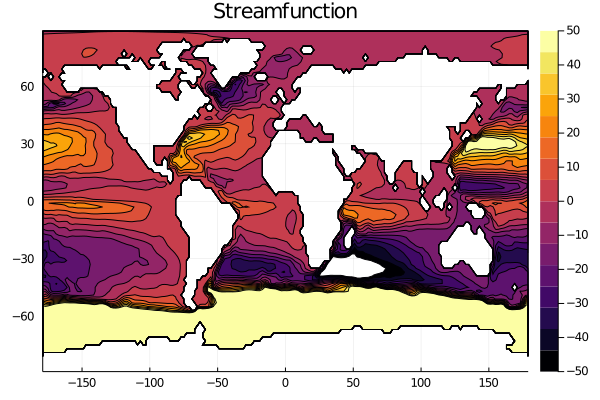

In [19]:
TrspPsiI=Interpolate(1e-6*μ*TrspPsi,λ.f,λ.i,λ.j,λ.w)
contourf(vec(λ.lon[:,1]),vec(λ.lat[1,:]),
    TrspPsiI,title="Streamfunction",clims=(-50,50))

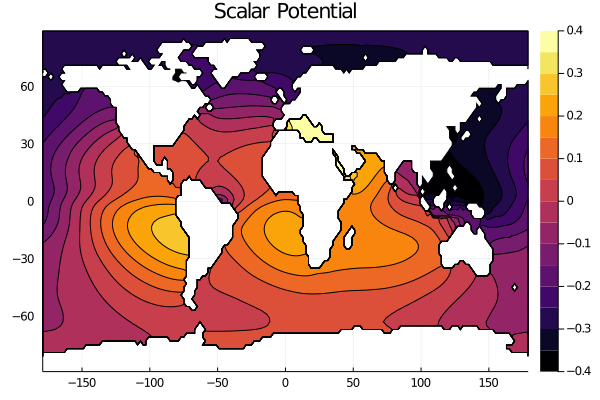

In [21]:
TrspPotI=Interpolate(1e-6*μ*TrspPot,λ.f,λ.i,λ.j,λ.w)
contourf(vec(λ.lon[:,1]),vec(λ.lat[1,:]),
        TrspPotI,title="Scalar Potential",clims=(-0.4,0.4))